# Детекция масок (Faster RCNN)

## Импорт библиотек

In [3]:
# Для загрузки и анализа данных
import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

import cv2
import squarify
import matplotlib.pyplot as plt
%matplotlib inline

# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [2]:
# Путь до папки с датасетом
DATASET_PATH = "/kaggle/input/face-mask-detection"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

# Функция для парсинга xml-файлов
def xml_to_csv(path=ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [3]:
xml_df = xml_to_csv()
print('Successfully converted xml to csv.')

100%|██████████| 853/853 [00:05<00:00, 146.34it/s]

Successfully converted xml to csv.


In [4]:
xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax
0,maksssksksss737.png,400,226,with_mask,28,55,46,71
1,maksssksksss737.png,400,226,with_mask,98,62,111,78
2,maksssksksss737.png,400,226,mask_weared_incorrect,159,50,193,90
3,maksssksksss737.png,400,226,with_mask,293,59,313,80
4,maksssksksss737.png,400,226,with_mask,352,51,372,72


Далее из-за выходящих за пределы изображения bbox-ов могут возникнуть ошибки, поэтому мы вручную пофиксим такие случаи.

In [5]:
xml_df.query("width < xmax")

,filename,width,height,name,xmin,ymin,xmax,ymax
471,maksssksksss603.png,400,278,with_mask,397,132,401,142
487,maksssksksss603.png,400,278,without_mask,396,18,401,23
699,maksssksksss93.png,400,267,with_mask,388,72,401,92
829,maksssksksss5.png,400,266,without_mask,364,30,401,66
1233,maksssksksss457.png,400,300,with_mask,389,56,401,83
1426,maksssksksss251.png,400,206,with_mask,373,76,401,114
1749,maksssksksss110.png,400,267,without_mask,381,14,401,34
2625,maksssksksss616.png,400,267,with_mask,394,92,401,111
3253,maksssksksss787.png,400,288,with_mask,360,79,401,139
3268,maksssksksss706.png,400,267,with_mask,368,162,401,219


In [6]:
xml_df.loc[xml_df['xmax'] > xml_df['width'], 'xmax'] -= 1

In [7]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 4072
Количество изображений в датафрэйме 853


## Обработка данных

Закодируем классы обьектов.

In [8]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,class
0,maksssksksss737.png,400,226,with_mask,28,55,46,71,1
1,maksssksksss737.png,400,226,with_mask,98,62,111,78,1
2,maksssksksss737.png,400,226,mask_weared_incorrect,159,50,193,90,0
3,maksssksksss737.png,400,226,with_mask,293,59,313,80,1
4,maksssksksss737.png,400,226,with_mask,352,51,372,72,1


In [9]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
labels_dict = dict(zip(mapping.values(), mapping.keys()))
labels_dict

{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

## Формируем датасет

Разделим выборку на train и val.

In [10]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
valid_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Число изображений: {len(image_ids)}')
print(f'Объем train выборки: {len(train_ids)}')
print(f'Объем valid выборки: {len(valid_ids)}')

Число изображений: 853
Объем train выборки: 682
Объем valid выборки: 171


In [43]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
train_df.to_csv('train_df.csv', index=None)
valid_df = xml_df[xml_df['filename'].isin(valid_ids)]
valid_df.to_csv('valid_df.csv', index=None)

А что там с балансом классов?

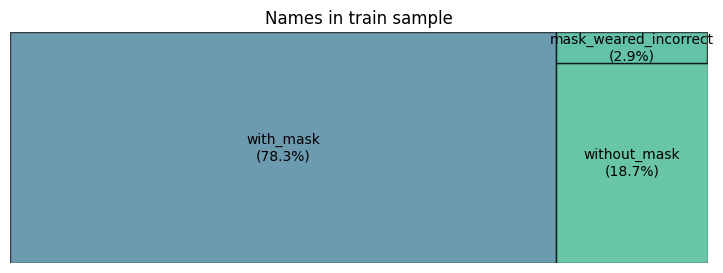

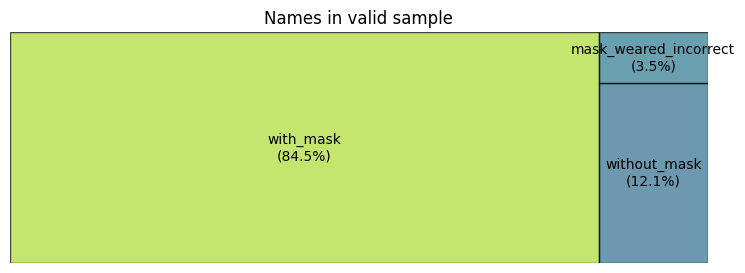

In [12]:
# Получаем распределение значений столбца 'name' с нормализацией
train_names_vls_cnts = train_df['name'].value_counts(normalize=True)
valid_names_vls_cnts = valid_df['name'].value_counts(normalize=True)

# Функция для получения иерархической диаграммы
def get_hierarchical_diagram(vls_cnts, sample='train'):
    plt.figure(figsize=(9, 3))
    squarify.plot(
        sizes=vls_cnts,
        label=[f'{label}\n({value:.1%})' for label, value in zip(
            vls_cnts.index, vls_cnts
            )],
        alpha=0.7, edgecolor='black')
    plt.axis('off')  
    plt.title(f'Names in {sample} sample')
    plt.show()
    
for vls_cnts, sample_name in [(train_names_vls_cnts, 'train'), (valid_names_vls_cnts, 'valid')]:
    get_hierarchical_diagram(vls_cnts, sample=sample_name)

Выборки по составу отличаются не очень сильно, однако налицо сильный дисбаланс классов.

Идем дальше. Пропишем функцию для аугментации:

In [13]:
# Функция для аугментации данных
def get_transforms(phase):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            A.Flip(p=0.5),
            ])
    list_transforms.extend([ToTensorV2(),])
    list_trms = A.Compose(
        list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']}
    )

    return list_trms

Напишем класс `Face_Mask_Dataset()` для загрузки данных в модель.

In [14]:
class FaceMaskDataset(Dataset):
    def __init__(self, df, image_dir, width, height, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.height = height
        self.width = width
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        
        wt = image_arr.shape[1]
        ht = image_arr.shape[0]
        
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr = cv2.resize(image_arr, (self.width, self.height), cv2.INTER_AREA)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        boxes[:, 0] = boxes[:, 0] / wt * self.width
        boxes[:, 1] = boxes[:, 1] / ht * self.height
        boxes[:, 2] = boxes[:, 2] / wt * self.width
        boxes[:, 3] = boxes[:, 3] / ht * self.height

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(
            tuple(map(torch.tensor, zip(*sample['bboxes'])))
        ).permute(1, 0)

        return image, target, image_id


In [15]:
train_data = FaceMaskDataset(
    train_df, IMAGES_PATH, 480, 480, phase='train'
)
valid_data = FaceMaskDataset(
    valid_df, IMAGES_PATH, 480, 480, phase='validation'
)

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(valid_data)}')

Размер обучающей выборки 682
Размер валидационной выборки 171


In [16]:
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Визуализация данных

In [22]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    plt.figure(figsize=(10, 8))
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes']
    BOX_COLOR = (0, 255, 0)

    for j, box in enumerate(bbox):
        class_name = labels_dict[img[1]['labels'][j].item()]
        cv2.rectangle(
            image, (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            BOX_COLOR, thickness=1
            )
        ((text_width, text_height), _) = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        cv2.rectangle(
            image, (int(box[0]), int(box[1]) - int(1.3 * text_height)),
            (int(box[0]) + text_width, int(box[1])), BOX_COLOR, -1
            )
        cv2.putText(
            image,
            text=class_name,
            org=(int(box[0]), int(box[1]) - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35,
            color=(255, 255, 255),
            lineType=cv2.LINE_AA,
        )
    plt.imshow(image)
    plt.show()

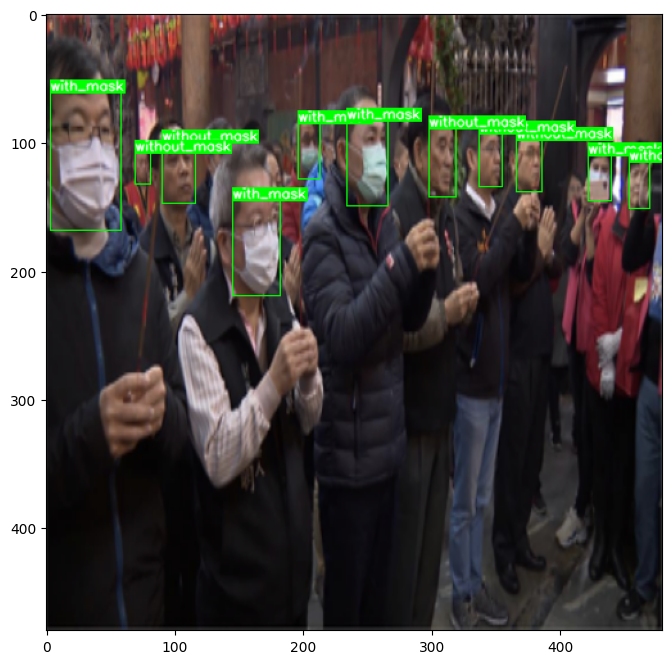

In [52]:
# Выберем рандомный индекс и выведем
# преобразованное изображение из датасета
random_image_idx = np.random.choice(range(len(train_data)))
plot_img(train_data, random_image_idx)

## Загрузка модели

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


Загружаем предобученную модель.

In [30]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='COCO_V1')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 156MB/s]  


In [31]:
num_classes = len(np.unique(xml_df['class']))
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

print(model.roi_heads)
# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads)

Число классов: 3
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): FastRCNNConvFCHead(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3),

In [32]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params, lr=1e-4, weight_decay=0.0005
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=0.9
)


# optimizer = torch.optim.SGD(
#     params, lr=0.005, momentum=0.9, weight_decay=0.0005
# )
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=3,gamma=0.1
# )

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.Внутри функций мы переводим все данные внутри бача на устройство, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную `running_loss` для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [33]:
def train(train_dataloader, rep_freq=10):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        losses.backward()
        optimizer.step()
        if i % rep_freq == 0:
            print(f"\tИтерация #{i} losses: {losses}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(valid_dataloader):
    running_loss = 0
    for data in valid_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    val_loss = running_loss/len(valid_dataloader.dataset)
    return val_loss

## Обучение

Начинаем обучение. Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [34]:
NUM_EPOCHS = 10
REP_FREQ = 100

train_losses = []
val_losses = []
try:
    for epoch in range(NUM_EPOCHS):
        start = time()
        train_loss = train(train_data_loader, rep_freq=REP_FREQ)
        val_loss = val(valid_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch + 1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch + 1} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 losses: 1.780066488562858


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.2921445781495468
Эпоха #1 train_loss: 0.10045063609224986, val_loss: 0.06613167860341164
Потрачено 2.1 минут на 1 эпоху
	Итерация #0 losses: 0.3065708142941921


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.24677509002898193
Эпоха #2 train_loss: 0.06769273508847615, val_loss: 0.06510822671732194
Потрачено 2.0 минут на 2 эпоху
	Итерация #0 losses: 0.2944399414106822


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.18679730709589898
Эпоха #3 train_loss: 0.05966361754662083, val_loss: 0.06434436419043531
Потрачено 2.0 минут на 3 эпоху
	Итерация #0 losses: 0.30098612243090206


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.21446044186070587
Эпоха #4 train_loss: 0.05398488233455999, val_loss: 0.06057737160141395
Потрачено 2.0 минут на 4 эпоху
	Итерация #0 losses: 0.3202164159200733


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.19609846954248758
Эпоха #5 train_loss: 0.04954321891679025, val_loss: 0.05765550836015687
Потрачено 2.0 минут на 5 эпоху
	Итерация #0 losses: 0.2410955015744296


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.18344289578975528
Эпоха #6 train_loss: 0.046009628617067255, val_loss: 0.06211999614471332
Потрачено 2.0 минут на 6 эпоху
	Итерация #0 losses: 0.2444313627847491


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.10595386114322941
Эпоха #7 train_loss: 0.04480682858487543, val_loss: 0.06152227200333581
Потрачено 2.0 минут на 7 эпоху
	Итерация #0 losses: 0.21934453498103337


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.10661400459124123
Эпоха #8 train_loss: 0.040898830952515494, val_loss: 0.059334093653230856
Потрачено 2.0 минут на 8 эпоху
	Итерация #0 losses: 0.17742769645457174


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.1317730814225868
Эпоха #9 train_loss: 0.03781800552385729, val_loss: 0.05953216282022384
Потрачено 2.0 минут на 9 эпоху
	Итерация #0 losses: 0.17654264819102303


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


	Итерация #100 losses: 0.11123143625756111
Эпоха #10 train_loss: 0.03632814719571598, val_loss: 0.059295456507629664
Потрачено 2.0 минут на 10 эпоху


Визуализируем динамику лоссов

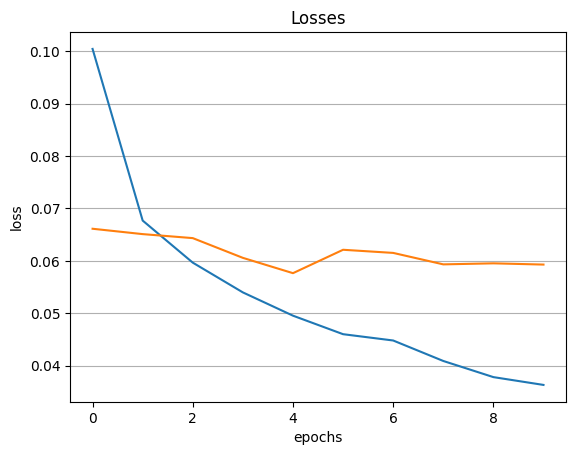

In [35]:
plt.title('Losses')
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(axis='y')
plt.show()

## Предсказание

Напишем функцию для получения предсказаний по интересующей нас выборке

In [37]:
def eval_fn(data_loader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)
        
            for i in range(len(images)):
                boxes = output[i]['boxes'].detach().cpu().numpy()
                labels = output[i]['labels'].detach().cpu().numpy()
                scores = output[i]['scores'].detach().cpu().numpy()

                all_predictions.append({
                    'pred_boxes': (boxes).astype(int),
                    'labels': (labels).astype(int),
                    'scores': scores,
                    'true_boxes': (targets[i]['boxes'].cpu().numpy()).astype(int),
                    'true_labels': (targets[i]['labels'].cpu().numpy()).astype(int),
                    'image_id': image_ids[i]
                })

    return all_predictions

In [38]:
all_predictions = eval_fn(valid_data_loader, model, device)

100%|██████████| 43/43 [00:17<00:00,  2.44it/s]


Соберем из предсказаний таблицу. 

In [44]:
preds_rows = []
for entry in all_predictions:
    for i in range(len(entry['pred_boxes'])):
        preds_rows.append(
            [entry['pred_boxes'][i][0],
             entry['pred_boxes'][i][1],
             entry['pred_boxes'][i][2],
             entry['pred_boxes'][i][3],
             entry['labels'][i],
             labels_dict[entry['labels'][i]],
             entry['scores'][i],
             entry['image_id'] + '.png']
             )

preds_df = pd.DataFrame(
    preds_rows,
    columns=[
        'xmin', 'ymin', 'xmax', 'ymax',
        'class', 'name', 'scores', 'filename'
    ]
)

preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,111,59,140,116,1,with_mask,0.997546,maksssksksss535.png
1,423,78,441,108,1,with_mask,0.996878,maksssksksss535.png
2,380,64,395,93,1,with_mask,0.996729,maksssksksss535.png
3,52,70,69,103,1,with_mask,0.994852,maksssksksss535.png
4,279,89,289,107,2,without_mask,0.966982,maksssksksss535.png


In [45]:
#Сохраняем полученные предсказания
preds_df.to_csv('preds_df.csv', index=False)

In [5]:
preds_df = pd.read_csv('preds_df.csv')

preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,111,59,140,116,1,with_mask,0.997546,maksssksksss535.png
1,423,78,441,108,1,with_mask,0.996878,maksssksksss535.png
2,380,64,395,93,1,with_mask,0.996729,maksssksksss535.png
3,52,70,69,103,1,with_mask,0.994852,maksssksksss535.png
4,279,89,289,107,2,without_mask,0.966982,maksssksksss535.png


In [6]:
print('Число предсказаний:     ', preds_df.shape[0])
print('Число реальных объектов:', valid_df.shape[0])

Число предсказаний:      945
Число реальных объектов: 695


Посмотрим, насколько предсказания охватывают состав валидационной выборки.

In [47]:
set1 = set(list(preds_df.filename.values))
set2 = set(list(valid_df.filename.values))
intersection = set1.intersection(set2)
union_set = set1 | set2

print(len(intersection) / len(union_set))
print(preds_df.filename.nunique(), valid_df.filename.nunique())

1.0
171 171


## Визуализация предсказаний

In [10]:
# Функция для рассчета площади пересечения двух прямоугольников
def calculate_iou(box1, box2):
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou


def draw_predict(filename, iou_threshold=0.5, score_threshold=0.15):
    for i in range(len(valid_data)):
        if valid_data[i][-1] == filename.split('.')[0]:
            img = image_convert(valid_data[i][0])
            wt = img.shape[1]
            ht = img.shape[0]
    
    preds = preds_df[preds_df['filename'].isin([filename])]
    true = valid_df[valid_df['filename'].isin([filename])]
        
    for j in range(len(preds)):
        for k in range(len(true)):
            pred_box = preds.iloc[j][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            true_box = true.iloc[k][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            
            true_box['xmin'] = true_box['xmin'] / true.iloc[k]['width'] * wt
            true_box['ymin'] = true_box['ymin'] / true.iloc[k]['height'] * ht
            true_box['xmax'] = true_box['xmax'] / true.iloc[k]['width'] * wt
            true_box['ymax'] = true_box['ymax'] / true.iloc[k]['height'] * ht
            
            iou = calculate_iou(pred_box, true_box)
            score = preds['scores'].values[j]
            if (iou > iou_threshold) and (score > score_threshold):
                label = preds['name'].values[j]
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin']),
                    (pred_box['xmax'], pred_box['ymax']),
                    (255, 0, 0), thickness=1
                )
                ((text_width, text_height), _) = cv2.getTextSize(
                    f"{label} {score:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
                )
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin'] - 3 - int(1.3 * text_height)),
                    (pred_box['xmin'] + text_width, pred_box['ymin']), (255, 0, 0), -1
                )
                cv2.putText(img,
                    text=f"{label} {score:.2f}",
                    org=(pred_box['xmin'], pred_box['ymin'] - 3),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.35,
                    color=(255, 255, 255),
                    lineType=cv2.LINE_AA,
                )
                
    plt.figure(figsize=(10, 8))
    plt.imshow(img)

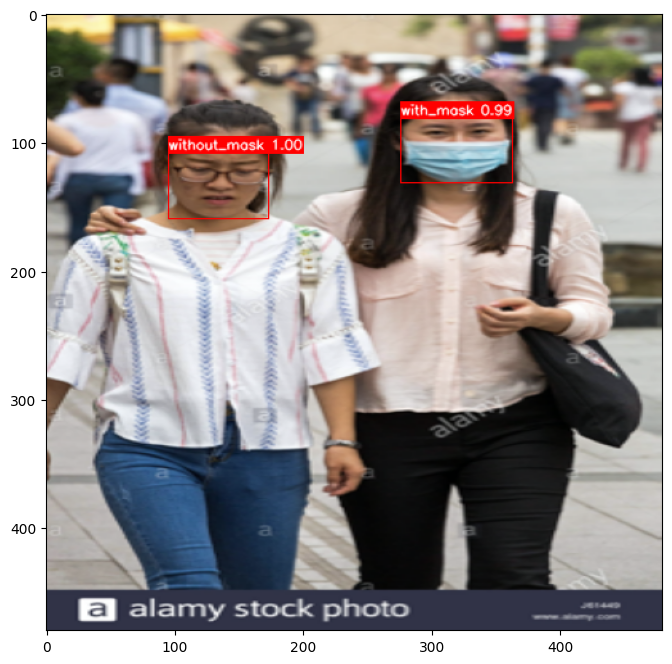

In [59]:
random_image_name = np.random.choice(list(preds_df.filename.unique()))
draw_predict(random_image_name, iou_threshold=0.5, score_threshold=0.1)

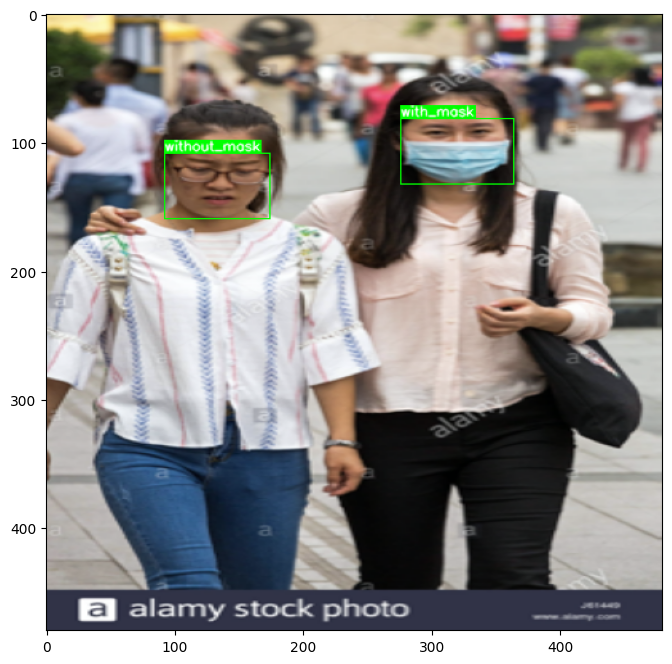

In [60]:
for i in range(len(valid_data)):
    if valid_data[i][-1] == random_image_name.split('.')[0]:
        plot_img(valid_data, i)

## Считаем precision и recall

In [37]:
def calculate_detection_precision_and_recall(
    width, height,
    true_df=valid_df, preds=preds_df,
    iou_threshold=0.5, confidence_threshold=0.25,
    get_report=False
    ):
    true_val_cnts_dct = dict(true_df.name.value_counts())
    pred_true_cnts_dct = {key: 0 for key in list(true_val_cnts_dct.keys())}
    pred_false_cnts_dct = {key: 0 for key in list(true_val_cnts_dct.keys())}
    
    for filename in list(true_df.filename.unique()):
        true_boxes = true_df[true_df['filename'] == filename]
        pred_boxes = preds[preds['filename'] == filename]
        wt = true_df[true_df['filename'] == filename]['width'].values[0]
        ht = true_df[true_df['filename'] == filename]['height'].values[0]
        
        for _, true_row in true_boxes.iterrows():
            true_detecting = [0]
            false_detecting = [0]
            
            true_box = {
                'xmin': true_row['xmin'],
                'ymin': true_row['ymin'],
                'xmax': true_row['xmax'],
                'ymax': true_row['ymax']
            }
            true_class = true_row['name']
            for _, pred_row in pred_boxes.iterrows():
                confidence = pred_row['scores']
                if confidence >= confidence_threshold:
                    pred_box = {
                        'xmin': pred_row['xmin'] / width * wt,
                        'ymin': pred_row['ymin'] / height * ht,
                        'xmax': pred_row['xmax'] / width * wt,
                        'ymax': pred_row['ymax'] / height * ht
                    }
                    
                    pred_class = pred_row['name']
                    
                    iou = calculate_iou(pred_box, true_box)
                    if iou >= iou_threshold:
                        if pred_class == true_class:
                            true_detecting.append(1)
                        else:
                            false_detecting.append(1)
            
            pred_true_cnts_dct[true_class] += max(true_detecting)
            pred_false_cnts_dct[true_class] += max(false_detecting)
    
    all_true_positive = sum(list(pred_true_cnts_dct.values()))
    all_false_positive = sum(list(pred_false_cnts_dct.values()))
    
    if (all_true_positive + all_false_positive) != 0:
        recall = all_true_positive / len(true_df)
        precision = all_true_positive / (all_true_positive + all_false_positive)
    else:
        recall, precision = 0, 0
       
    if get_report:
        print('Class name'.ljust(21), '| Recall | Precision | true | pred |')
        print('-'*58)
        for k, v in true_val_cnts_dct.items():
            true_positive = pred_true_cnts_dct[k]
            false_positive = pred_false_cnts_dct[k]
            print(
                f'{k}'.ljust(21), f'| {true_positive/v:.4f}'.ljust(8),
                f'| {true_positive/(true_positive + false_positive):.4f}'.ljust(11),
                f'| {v}'.ljust(6), f'| {true_positive}'.ljust(6), '|')
        print('-'*58)
        print(f'Total Recall:    {recall:.4f}')
        print(f'Total Precision: {precision:.4f}')
    else:
        return precision, recall

Можем построить поверхность accuracy при различных значениях IoU и уверенности модели.

In [38]:
iou_thresholds = np.arange(0, 1.1, 0.1)
confidence_thresholds = np.arange(0, 1.1, 0.1)
params_with_accuracy_lst = []

for i in tqdm(range(len(iou_thresholds))):
    
    for j in range(len(confidence_thresholds)):
        precision, recall = calculate_detection_precision_and_recall(
            480, 480,
            true_df=valid_df, preds=preds_df,
            iou_threshold=iou_thresholds[i],
            confidence_threshold=confidence_thresholds[j]
            )
        
        params_with_accuracy_lst.append([
            iou_thresholds[i], confidence_thresholds[j], precision, recall
            ])

iou, confidence, precision, recall = [], [], [], []

# Разбиваем список списков на три списка
for sublist in params_with_accuracy_lst:
    iou.append(sublist[0])
    confidence.append(sublist[1])
    precision.append(sublist[2])
    recall.append(sublist[3])

100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


In [45]:
import plotly.express as px

# df = pd.DataFrame(
#     data=params_with_accuracy_lst,
#     columns=['IoU', 'Confidence', 'Precision', 'Recall']
# )
# fig = px.scatter_3d(
#     df, x='IoU', 
#     y='Confidence',
#     z='Precision')

# fig.show()

# fig = px.scatter_3d(
#     df, x='IoU', 
#     y='Confidence',
#     z='Recall')

# fig.show()

|Precision|Recall|
|-|-|
|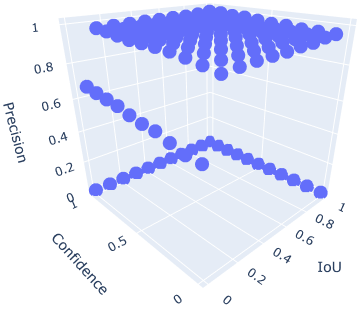|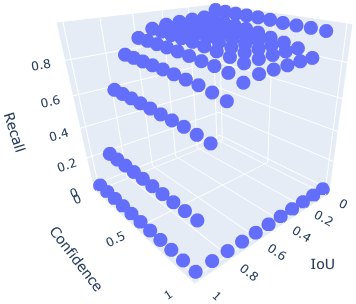|

Precision помимо граничных случае держится приблизительно на одном уровне: метрика не зависит от истинного числа меток, но показывает способность модели при заданных параметрах (изменение объема выборки) удачно предсказывать класс объекта: в нашем случае модель хорошо справляется с этим. Recall же привязан к общему числу объектов каждого класса и с увеличением требования по IoU будет падать.

Требуемыми можно счесть значение confidence от 0.25, IoU — от 0.5 (хорошим считается 0.7).

In [46]:
iou, conf = 0.7, 0.5
print(f'Report for IoU: {iou}; Confidence: {conf}')
calculate_detection_precision_and_recall(
    480, 480,
    valid_df, preds_df,
    iou_threshold=iou,
    confidence_threshold=conf,
    get_report=True
)

Report for IoU: 0.7; Confidence: 0.5
Class name            | Recall | Precision | true | pred |
----------------------------------------------------------
with_mask             | 0.8160 | 0.9979    | 587  | 479  |
without_mask          | 0.6905 | 0.9667    | 84   | 58   |
mask_weared_incorrect | 0.0000 | 0.0000    | 24   | 0    |
----------------------------------------------------------
Total Recall:    0.7727
Total Precision: 0.9693
